# Asset Swap formulas

The total cashﬂow of a swap with grid times $T_i$, of strike $K$ and maturity $T = T_n$ upon an asset $(S_t)_{t\in \mathbb{R}^+}$, with $T_0 = 0$ is given by:

\begin{equation*}
C = \sum_{i=1}^n \Delta_{T_i} (S_{T_{i-1}} - K)
\end{equation*}

with $\Delta_{T_i} = T_{i} - T_{i-1}$, noting that the first coupon payment occurs at $t=T_1$

## Price computation

The price of this asset swap $P_t$ at time $t$ is given by the following formula:

\begin{equation*}
P_t = \beta_t^{-1} \mathbb{E}_t \left( \sum_{i=1}^n \beta_{T_i} \Delta_{T_i} (S_{T_{i-1}} - K) \right)
\end{equation*}

with $\beta_t$ the discout factor given by $\beta_t = \exp -\int_{0}^t r_s ds$

## Strike computation

The strike of the contract is the unique value which yields to $P_0 = 0$. In order to do so we have:

\begin{align*}
0 &=& \mathbb{E} \left( \sum_{i=1}^n \beta_{T_i} \Delta_{T_i} (S_{T_{i-1}} - K) \right) \\
&=& \sum_{i=1}^n \beta_{T_i} \Delta_{T_i} \mathbb{E} \left( S_{T_{i-1}} - K \right) \\
&=& \sum_{i=1}^n \frac{\beta_{T_i}}{\beta_{T_{i-1}}} \Delta_{T_i} \Big( \mathbb{E} \left( \beta_{T_{i-1}} S_{T_{i-1}} \right) - \beta_{T_{i-1}} K \Big) \\
&=& \sum_{i=1}^n \frac{\beta_{T_i}}{\beta_{T_{i-1}}} \Delta_{T_i} \Big( S_0 - \beta_{T_{i-1}} K \Big) \\
&=& S_0 \sum_{i=1}^n \frac{\beta_{T_i}}{\beta_{T_{i-1}}} \Delta_{T_i} - K \sum_{i=1}^n \beta_{T_i} \Delta_{T_i}
\end{align*}

which leads to:

\begin{equation*}
K = S_0 \frac{\sum_{i=1}^n \frac{\beta_{T_i}}{\beta_{T_{i-1}}} \Delta_{T_i}}{\sum_{i=1}^n \beta_{T_i} \Delta_{T_i}}
\end{equation*}

## Price of the contract

Now we can give the closed formula of the price for each $t>0$. Thus:

\begin{equation*}
P_t = \beta_t^{-1} \mathbb{E}_t \left( \sum_{i=1}^n \beta_{T_i} \Delta_{T_i} (S_{T_{i-1}} - K) \right)
\end{equation*}

We introduce $i^*$ which is the first index pillar such that $T_{i^*-1} \leq t < T_{i^*}$.

\begin{align*}
P_t &=& \beta_t^{-1} \left[ 
        \beta_{T_{i^*}} \Delta_{T_{i^*}} (S_{T_{i^*-1}} - K) + 
        \mathbb{E}_t \left( \sum_{j=i^*+1}^n \Delta_{T_j} \beta_{T_j} (S_{T_{j-1}} - K) \right) 
      \right] \\
    &=& \beta_t^{-1} \left[ 
            \beta_{T_{i^*}} \Delta_{T_{i^*}} (S_{T_{i^*-1}} - K) +         
            \sum_{j=i^*+1}^n \Delta_{T_j} \beta_{T_j} \mathbb{E}_t \left( 
                \frac{\beta_{T_{j-1}} S_{T_{j-1}}}{\beta_{T_{j-1}}} - K \right) 
        \right] \\
    &=& \beta_t^{-1} \left[ 
            \beta_{T_{i^*}} \Delta_{T_{i^*}} (S_{T_{i^*-1}} - K) +         
            \sum_{j=i^*+1}^n \Delta_{T_j} \beta_{T_j} \left( 
                \frac{\beta_{t} S_{t}}{\beta_{T_{j-1}}} - K \right)
        \right] \\       
    &=& \beta_{t}^{-1} \beta_{T_{i^*}} \Delta_{T_{i^*}} (S_{T_{i^*-1}} - K) + 
        S_t \sum_{j=i^*+1}^n \Delta_{T_j} \frac{\beta_{T_j}}{\beta_{T_{j-1}}} -
        K \beta_{t}^{-1} \sum_{j=i^*+1}^n \Delta_{T_j} \beta_{T_j}
\end{align*}

## Code

In [1]:
import sys

sys.path.append('../..')

In [2]:
from finance.discountfactor import ConstantRateDiscountFactor 

r = 0.02
discount = ConstantRateDiscountFactor(r)

In [3]:
import numpy as np
from scipy.stats import norm
from maths.montecarlo.processes.brownianmotions import GeometricBrownianMotion

maturity = 5.
step = 1./360
time_grid = GeometricBrownianMotion.generate_time_grid(0, maturity, step)

x_0 = [100]
mu_s = [[r]]
sigma_s = [0.3]

gbm = GeometricBrownianMotion(time_grid, x_0, mu_s, sigma_s)

In [4]:
print gbm.drifts
print gbm.vols

[[ 0.02]]
[[ 0.3]]


In [5]:
from finance.products.european.assetswap import (
    SwapContract,
)

delta = 0.25
coupon_dates = SwapContract.generate_payment_dates(0, maturity, delta)

swap = SwapContract(gbm, discount, coupon_dates)
print swap

Swap contract of maturity T = 5 years, over S^0 with strike K = 104.821, paying at {0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 3.75, 4.00, 4.25, 4.50, 4.75, 5.00}


### Test profile

In [6]:
p_fixed = 100.
strike = swap.strike

delta_times = swap.delta_time
discount_factors = [discount(t) for t in swap.pillars[1:]]

delta_beta_sum = np.dot(delta_times, discount_factors)

notional = p_fixed / (strike*delta_beta_sum)
print "Notional =",notional

Notional = 0.201002504172


In [7]:
N = 100
prices = np.zeros((N, len(time_grid)))

for i in range(N):
    gbm.simulate()
    for (j, t) in enumerate(time_grid):
        prices[i, j] = notional*swap.price(t)

In [8]:
q95 = np.percentile(prices, 97.5, axis=0)
q5 = np.percentile(prices, 2.5, axis=0)
price_avg = np.mean(prices, 0)

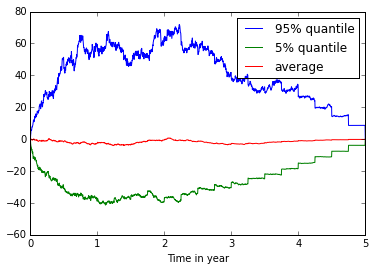

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.xlabel('Time in year')
plt.plot(time_grid, q95, label='95% quantile')
plt.plot(time_grid, q5, label='5% quantile')
plt.plot(time_grid, price_avg, label='average')
plt.legend(loc='best')
plt.show()